## 使用GAN生成手写数字的demo
参考[网站](https://www.shenxiaohai.me/pytorch-tutorial-advanced-01/)

### 预处理阶段

In [1]:
# 包
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

/home/cxmd/mambaforge/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/cxmd/mambaforge/envs/pytorch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# 超参数设置
latent_size = 64        # 输入噪声的维数
hidden_size = 256       # 隐藏层大小
image_size = 28*28      # 图片大小
num_epochs = 200        # 训练轮数
batch_size = 100      # m每批次的数据量
sample_dir = 'samples'

In [4]:
# 如果没有文件夹就创建一个文件夹
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [5]:
# 图像处理模块：transform设置
# Image processing: 归一化
transform = transforms.Compose(
    [
        transforms.ToTensor(),     # 将图像转换为PyTorch张量
        # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),    # 这里默认为RGB三个通道
        # torchvision.transforms.Resize(28),  # 将图像的大小调整为28x28
        torchvision.transforms.Normalize([0.5], [0.5]),  # 将图像的像素值标准化到[-1, 1]，因为ToTensor()将像素值转换为[0, 1]
    ]
)

### MNIST数据集

In [6]:
# 加载同时做transform预处理
mnist = torchvision.datasets.MNIST(
    root='/home/cxmd/文档/data_for_AI_train/mnist_data',    # 数据集的保存位置
    train=True,    # 是否获取训练集，如果为False，则获取测试集
    download=True,    # 如果数据集不存在，是否自动下载
    transform=transform,
)

In [7]:
# 数据加载器：GAN中只考虑判别模型和生成模型的对抗提高，无需设置训练集和测试集
data_loader = torch.utils.data.DataLoader(
    dataset=mnist,
    batch_size=batch_size,
    shuffle=True,      # 每次训练周期开始时打乱数据
)

### 判别器和生成器模型构建

In [8]:
# 创建判别器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),    # 当x小于0时，输出为0.2*x
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [9]:
# 创建生成器
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size), # 生成的输入是随机数，可以自己定义
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(),
)

In [10]:
# 拷贝到GPU
D = D.to(device)
G = G.to(device)

In [11]:
# 设置损失函数和优化器
criterion = nn.BCELoss()    # 二元交叉熵损失函数

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [12]:
# 定义两个函数

def denorm(x):
    # 使原本在[-1, 1]范围内的x变换到[0, 1]范围内
    out = (x + 1) / 2
    # 使用clamp函数确保所有的输出值都在[0, 1]范围内
    # 如果out中有小于0的值，它们会被设为0
    # 如果有大于1的值，它们会被设为1
    return out.clamp(0, 1)


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

### 生成对抗训练
分两步：  
1. 固定生成器，优化判别器
2. 固定判别器，优化生成器

In [13]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # 创建标签，随后会用于损失函数BCE loss的计算
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # ================================================================== #
        #                      训练判别模型                      #
        # ================================================================== #
        
        # 计算real损失
        # 使用公式 BCE_Loss(x, y) = -y * log(D(x)) - (1 - y) * log(1 - D(x)),来计算realimage的判别损失
        # 其中第二项永远为零，因为real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        
        # 计算fake损失
        # 生成器根据随机输入生成fake_images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        # 使用公式 BCE_Loss(x, y) = -y * log(D(x)) - (1 - y) * log(1 - D(x)),来计算fakeimage的判别损失
        # 其中第一项永远为零，因为fake_labels == 0
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 反向传播优化
        d_loss = d_loss_real + d_loss_fake     # 有个细节：本来要固定G，找到使损失最大时的D,但由于使用BCE_Loss函数计算时自动添加了负号，因此变为还是求损失函数的最小值，所以仍然可以通过后向传播更新参数
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                      训练生成模型                        #
        # ================================================================== #
        
        # 生成器根据随机输入生成fake_images，然后使用判别器进行判别
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # 训练生成模型，使之最大化 log(D(G(z)) ，而不是最小化 log(1-D(G(z)))
        # 具体的解释在原文第三小节最后一段有解释
        # 大致含义就是在训练初期，生成模型G还很菜，判别模型会以很高的置信度拒绝样本，因为这些样本与训练数据明显不同。
        # 这样log(1-D(G(z)))就近乎饱和，梯度计算得到的值很小，不利于反向传播和训练。
        # 换一种思路，通过计算最大化log(D(G(z))，就能够在训练初期提供较大的梯度值，利于快速收敛
        g_loss = criterion(outputs, real_labels)     # 相当于求-log(D(G(z)的最小值
        
        # 反向传播和优化
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
            
    # 在第一轮保存训练数据图像
    if epoch == 0:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 每一论保存生成的样本(集fake_images)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch + 1)))

Epoch [0/200], Step [100/600], d_loss: 0.9321, g_loss: 0.6788, D(x): 0.93, D(G(z)): 0.58
Epoch [0/200], Step [200/600], d_loss: 0.8116, g_loss: 0.7046, D(x): 0.97, D(G(z)): 0.54
Epoch [0/200], Step [300/600], d_loss: 0.8454, g_loss: 0.6954, D(x): 0.95, D(G(z)): 0.55
Epoch [0/200], Step [400/600], d_loss: 0.7884, g_loss: 0.6913, D(x): 0.97, D(G(z)): 0.53
Epoch [0/200], Step [500/600], d_loss: 0.8149, g_loss: 0.6808, D(x): 0.98, D(G(z)): 0.55
Epoch [0/200], Step [600/600], d_loss: 0.8394, g_loss: 0.7195, D(x): 0.96, D(G(z)): 0.55
Epoch [1/200], Step [100/600], d_loss: 0.8725, g_loss: 0.6825, D(x): 0.93, D(G(z)): 0.55
Epoch [1/200], Step [200/600], d_loss: 0.9376, g_loss: 0.6658, D(x): 0.93, D(G(z)): 0.58
Epoch [1/200], Step [300/600], d_loss: 0.9387, g_loss: 0.6477, D(x): 0.92, D(G(z)): 0.57
Epoch [1/200], Step [400/600], d_loss: 1.0269, g_loss: 0.6655, D(x): 0.89, D(G(z)): 0.59
Epoch [1/200], Step [500/600], d_loss: 0.8690, g_loss: 0.6672, D(x): 0.93, D(G(z)): 0.55
Epoch [1/200], Step [

## 结果展示

In [22]:
# 导入包
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
import matplotlib.image as mpimg     # 用于读取图片
import numpy as np

#### real image

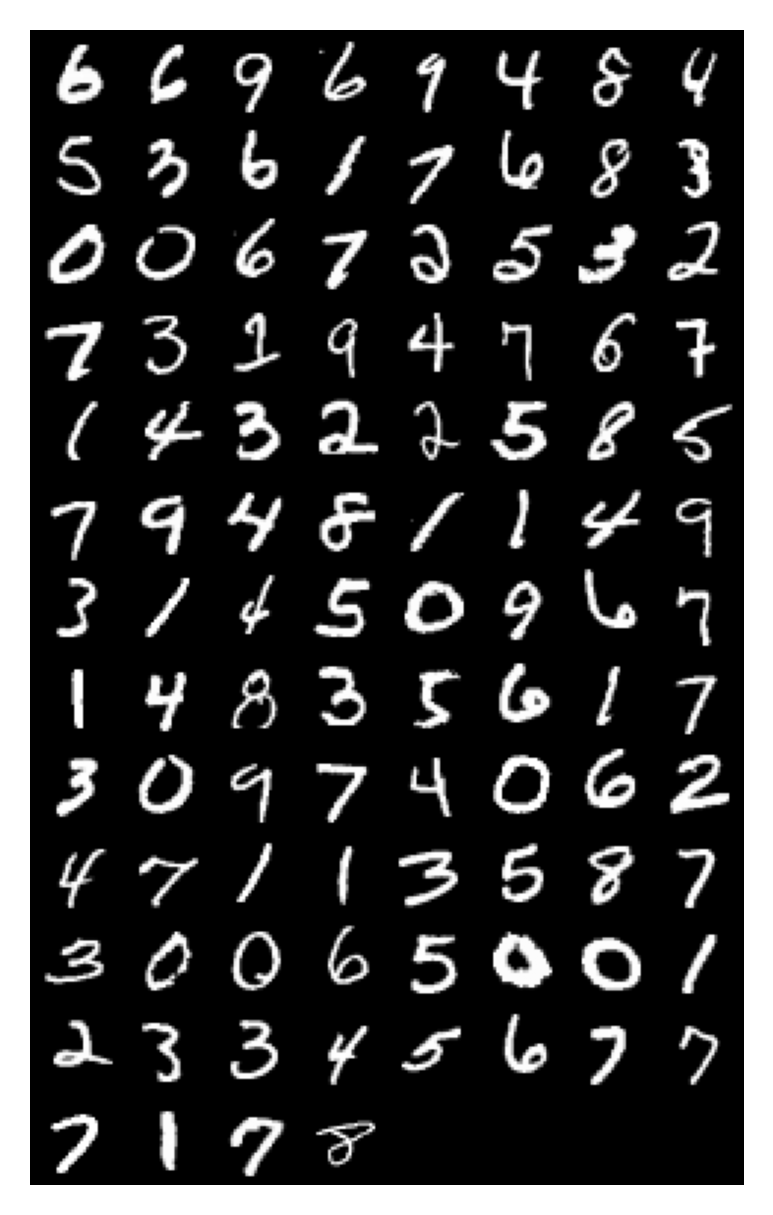

In [23]:
real_path = './samples/real_images.png'
realImage = mpimg.imread(real_path)
plt.imshow(realImage)
plt.axis('off')   # 不显示坐标轴
plt.show()

#### fake image进化过程

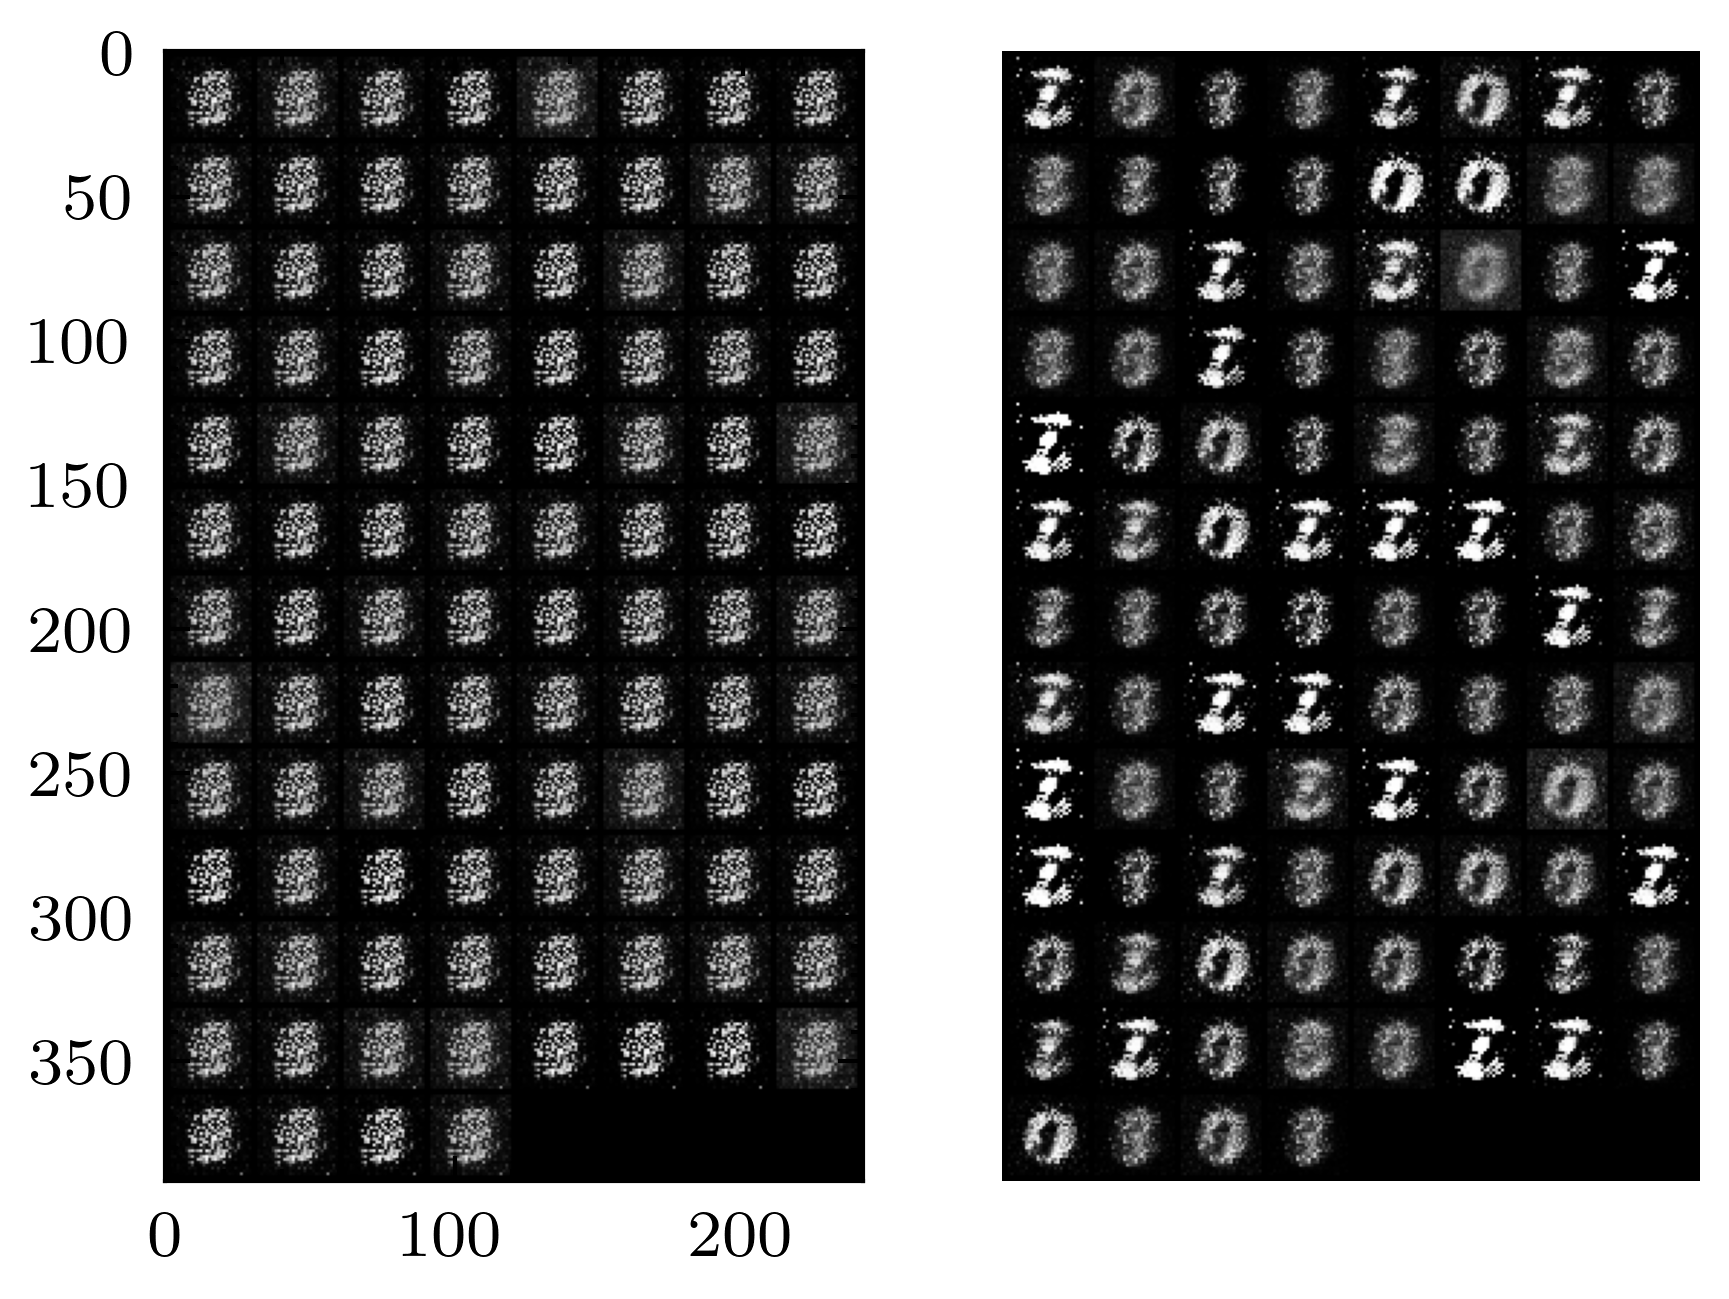

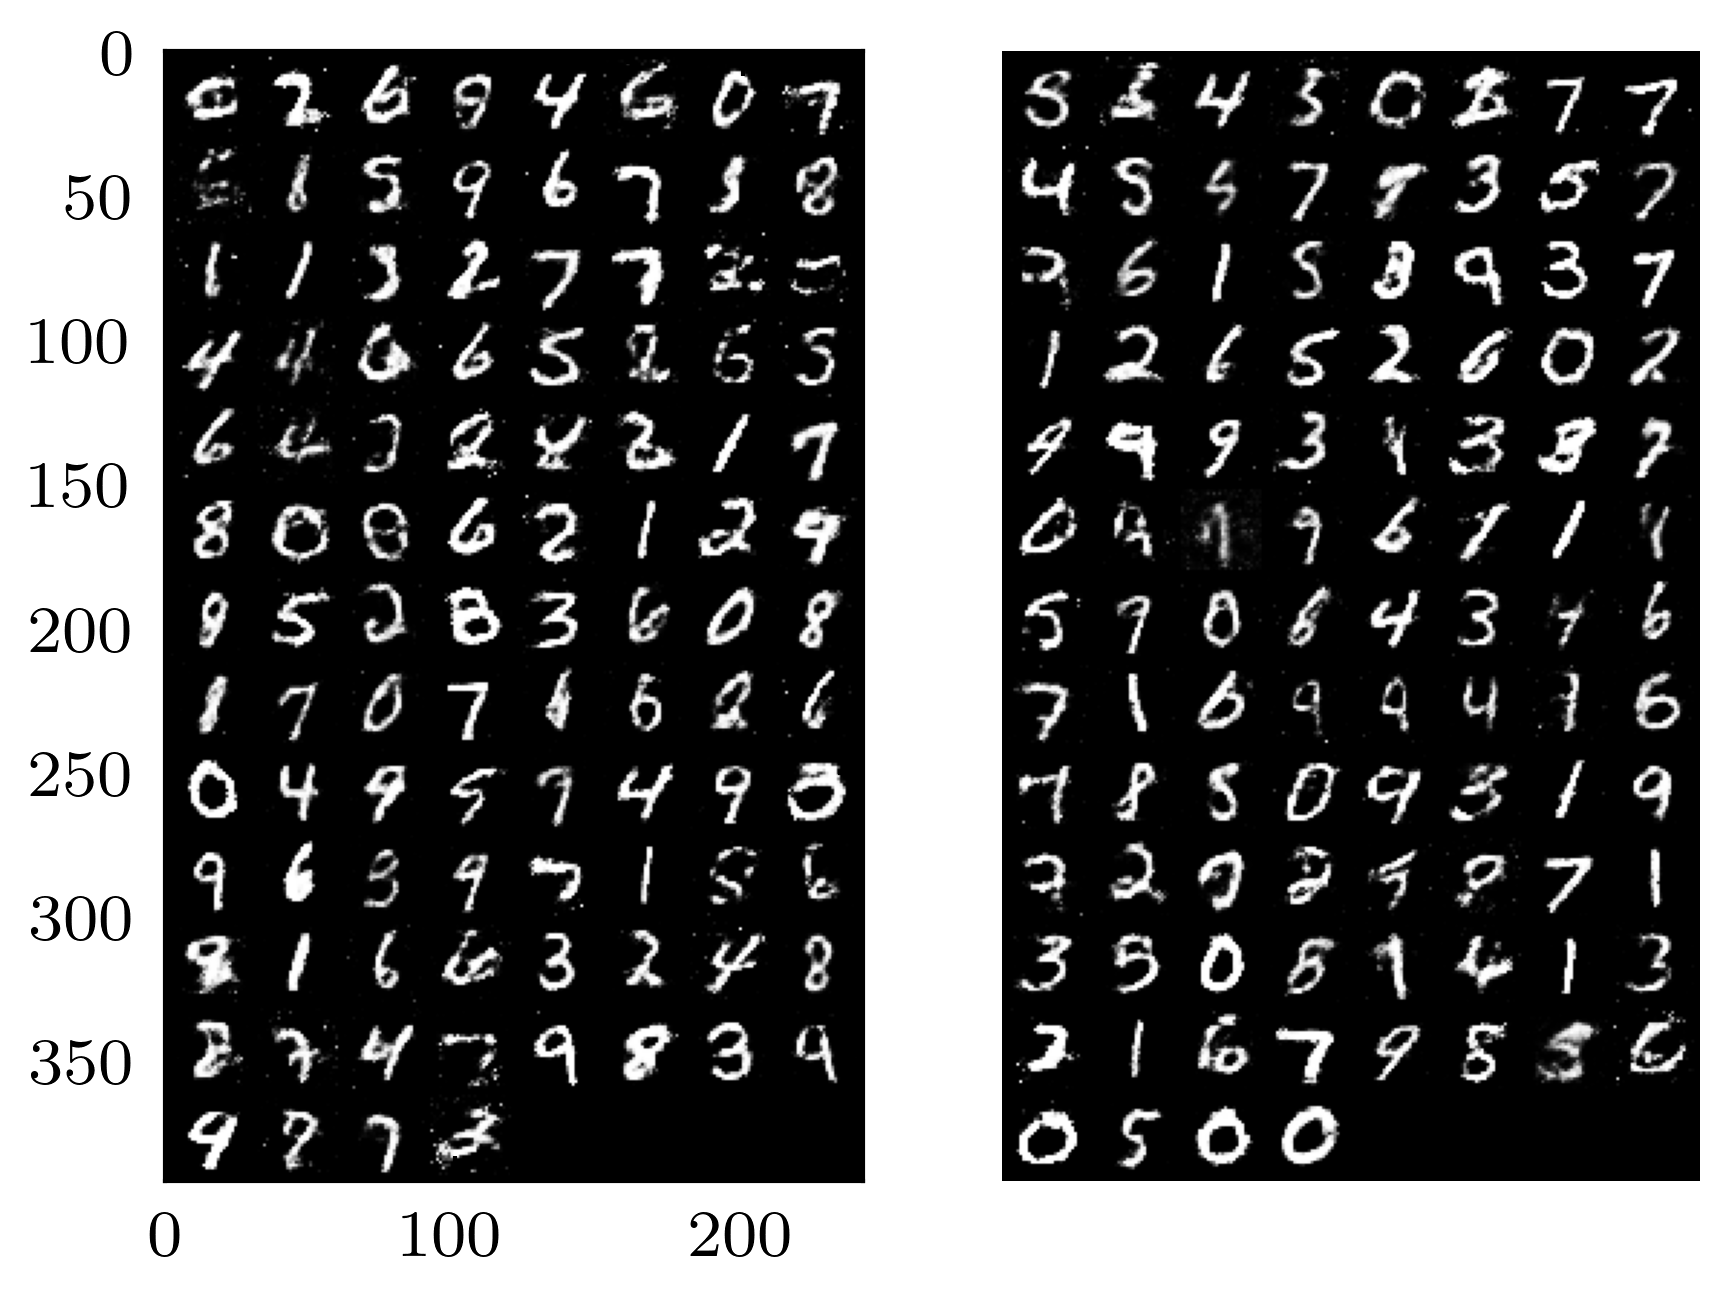

In [24]:
# 起始阶段
fakePath1 = './samples/fake_images-1.png'
fakeImg1 = mpimg.imread(fakePath1)

fakePath5 = './samples/fake_images-5.png'
fakeImg5 = mpimg.imread(fakePath5)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(fakeImg1)
ax[1].imshow(fakeImg5)
plt.axis('off')
plt.show()


fakePath195 = './samples/fake_images-195.png'
fakeImg195 = mpimg.imread(fakePath195)

fakePath200 = './samples/fake_images-200.png'
fakeImg200 = mpimg.imread(fakePath200)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(fakeImg195)
ax[1].imshow(fakeImg200)
plt.axis('off')
plt.show()
